Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved. SPDX-License-Identifier: Apache-2.0

# Ask the Graph
# Notebook 1: Prep Unstructured Data

In this notebook we prepare unstructured data, a set of press releases about organizations. This data complements the structured organization data we prepared in notebook 0. 

You DO NOT need to run this notebook. The notebook produces output that is already prepared for you and available in a public bucket. But you may wish to review how we prepared that data. In that case, follow along with the logic below.

Here is the input, sourced from s3://aws-neptune-customer-samples/tmls2024/source/. We download a local copy to the source folder:

- comprehend_events_amazon_press_releases.20201118.v1.4.1.jsonl: Press releases, including title, keywords, and text. This file also contains entities and events extracted from press releases using Amazon Comprehend.

We produce the following output locally:
- aos/chunks.jsonl - Chunks to load to OpenSearch vector store
- documents/*.txt - Press releases as .txt files 
- chunks/*/txt - Chunks of press releases as .txt files
- graphdata/rdf/documents.ttl - Press release documents and provenance to load to Neptune.
- graphdata/rdf/extractions.ttl - Entities and events extracted from press releases to load to Neptune.
- graphdata/rdf/resolved_entities.ttl - Link extracted entities to existing orgs, persons, industries, locations, products, and services in the graph.

That same data is available in:
s3://aws-neptune-customer-samples/tmls2024/aos/
s3://aws-neptune-customer-samples/tmls2024/graphdata/
s3://aws-neptune-customer-samples/tmls2024/documents/
s3://aws-neptune-customer-samples/tmls2024/chunks/

Here is our data model. This notebook prepares the unstructured sources (red boxes, upper third) and extracted facts (yellow boxes, middle third).

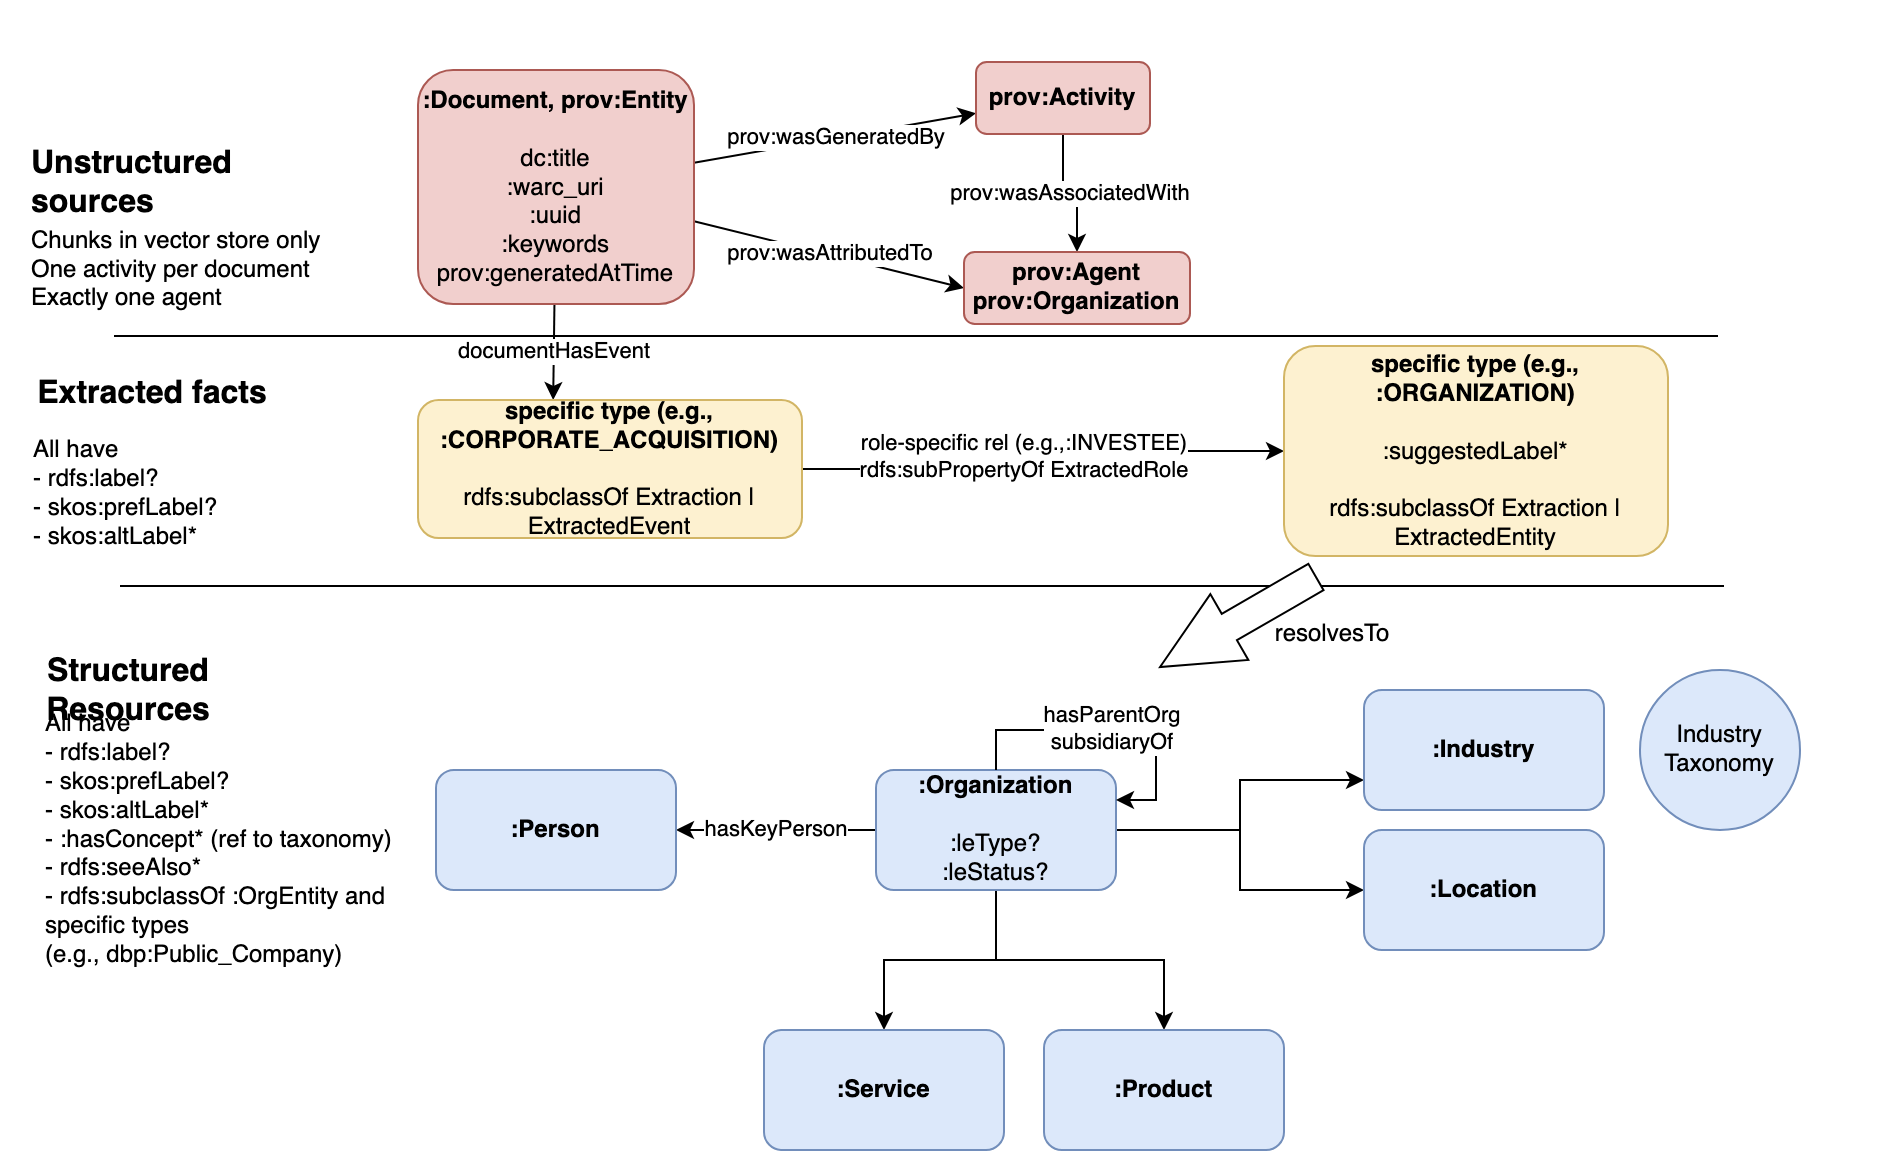

In the next notebook, we load prepared data into Neptune and OpenSearch for query.

## Install a few dependencies
We use Langchain very lightly

In [ ]:
!pip install -U langchain-community

In [ ]:
!pip install -q opensearch-py

In [ ]:
!pip install semchunk tiktoken

## Get source data and create output folders

In [ ]:
!aws s3 sync s3://aws-neptune-customer-samples-us-east-1/tmls2024/source/ source

In [ ]:
%%bash 
mkdir -p graphdata graphdata/rdf aos chunks documents

## Build press release documents

We have a set of press releases. These documents contain useful information that we would like to link to our base organization KG. 

In this set we build those documents and save to graphdata/rdf/documents.ttl

Also we write *.txt* files to the *documents* folder. The name of each file is *docid*.txt, where *docid* is the vertex ID of the document in the graph.
    

## The RAG-prep part: Summarize docs Chunk, embed, and extract files

In [ ]:
import pandas as pd
import csv, json
import rdf_helpers as rh
from rdflib import Graph, Literal, RDF, RDFS, URIRef, XSD, OWL, BNode, DC, SKOS, PROV

def make_document_uri(docid):
    return rh.make_uri(f"Document/{docid}")

rdf_file = rh.rdf_open()
press_center_uri=rh.make_uri("AmazonPressCenter")
rh.rdf_write(rdf_file, press_center_uri, RDF.type, PROV.Agent)
rh.rdf_write(rdf_file, press_center_uri, RDF.type, PROV.Organization)

# Open the JSONL file that contains the documents plus the Comprehend extraction. 
jsonObj = pd.read_json(path_or_buf="source/comprehend_events_amazon_press_releases.20201118.v1.4.1.jsonl", lines=True)
for index, row in jsonObj.iterrows():
    
    # extract metadata about current press release
    metadata=row['metadata']
    m_keywords=metadata['keywords']
    m_title=metadata['title']
    m_doc=metadata['document_id']
    m_date=metadata['common_crawl']['WARC-Date']
    m_uri=metadata['common_crawl']['WARC-Target-URI']
    doc_uri=make_document_uri(m_doc)    
    
    # write text to a file for chunking/embedding later
    with open(f"documents/{m_doc}.txt", "w") as f:
        f.write(row['raw_text'])
    
    rh.rdf_write(rdf_file, doc_uri, RDF.type, rh.make_uri("Document"))
    rh.rdf_write(rdf_file, doc_uri, RDF.type, PROV.Entity)
    rh.rdf_write(rdf_file, doc_uri, DC.title, Literal(m_title))
    rh.rdf_write(rdf_file, doc_uri, rh.make_uri("warc_uri"), Literal(m_uri))
    rh.rdf_write(rdf_file, doc_uri, rh.make_uri("uuid"), Literal(m_doc))
    rh.rdf_write(rdf_file, doc_uri, rh.make_uri("keywords"), Literal(m_keywords)) # could enhance later
    rh.rdf_write(rdf_file, doc_uri, PROV.generatedAtTime, Literal(m_date, datatype=XSD.date)) 
    rh.rdf_write(rdf_file, doc_uri, PROV.wasAttributedTo, press_center_uri)
              
    activity_uri=rh.make_uri(f"PRActivity_{m_doc}")
    rh.rdf_write(rdf_file,activity_uri, RDF.type, PROV.Activity)
    rh.rdf_write(rdf_file,activity_uri, PROV.wasAssociatedWith, press_center_uri)
    rh.rdf_write(rdf_file,activity_uri, PROV.generated,doc_uri)
    
    
rh.rdf_close(rdf_file, "graphdata/rdf/documents.ttl")

## Build Comprehend extraction results

We ran Amazon Comprehend to extract entities and events from the press releases. 

In this step, we build those extractions and link them to documents.

We produce graphdata/rdf/extractions.ttl.

For more on this approach, see blog post https://aws.amazon.com/blogs/database/building-a-knowledge-graph-in-amazon-neptune-using-amazon-comprehend-events/.


In [ ]:
# We will filter out names referring to each entity with less than 0.95 group certainty.
# You can change this threshold to be lower if you are tolerant of less certain values in your data set.
groupThreshold = 0.95

entities=[]
events=[]
ee_rels=[]
de_rels=[]
distinct_roles={}

def strip_x_id(rawid):
    return "_".join(rawid.split()).lower() # replace all whitespace with underscores

# Open the JSONL file that contains the documents plus the Comprehend extraction. 
jsonObj = pd.read_json(path_or_buf="source/comprehend_events_amazon_press_releases.20201118.v1.4.1.jsonl", lines=True)
for index, row in jsonObj.iterrows():
        
    # extract metadata about current press release
    metadata=row['metadata']
    m_doc=metadata['document_id']
    
    # Comprehend Events references entities it refers to by index, so we need to retain the ordered list of entities
    # within the document
    annotations = row['annotations']
    for entity in annotations["Entities"]:
        primary_name = entity["Mentions"][0]["Text"]
        entity_type =entity["Mentions"][0]["Type"]
        entity_local=strip_x_id(f"{entity_type}_{primary_name}")
        entity_id= rh.make_uri(f"ExtractedEntity/{entity_local}")
        names=[]
        for mention in entity["Mentions"]:
            if (mention["GroupScore"] >= groupThreshold):
                if not(mention["Text"] in names):
                        names.append(mention["Text"])
        entities.append({
            '~id': entity_id,
            'local_id': entity_local,
            '~label': 'ExtractedEntity',
            'label': primary_name,
            'labels': names,
            'type': entity_type
        })
        
    for event in annotations["Events"]:
        primary_name=event["Triggers"][0]["Text"]
        event_type=event["Type"]
        offset_for_id=str(event["Triggers"][0]["BeginOffset"])
        event_local=strip_x_id(f"{m_doc}_{event_type}_{primary_name}{offset_for_id}")
        event_id=rh.make_uri(f"ExtractedEvent/{event_local}")
        names=[]
        for trigger in event["Triggers"]:
            if not(trigger["Text"] in names):
                names.append(trigger["Text"])

        events.append({
            '~id': event_id,
            'local_id': event_local,
            '~label': 'ExtractedEvent',
            'label': primary_name,
            'labels': names,
            'type': event_type
        })

        # add edges between the event node and the entity node, 
        # annotated with a label describing the Comprehend Event role assigned to the entity in the event.
        for argument in event["Arguments"]:
            from_id=event_id
            from_local=event_local
            to_ent=entities[argument["EntityIndex"]]
            to_id=to_ent['~id']
            to_local=to_ent['local_id']
            edge_type=argument["Role"]
            ee_local=strip_x_id(f"{from_local}_{to_local}_{edge_type}")
            ee_edge_id=rh.make_uri(f"ExtractedEventToEntity/{ee_local}")
            role= argument["Role"]
            role_uri=rh.make_uri(f"ExtractedRole/{role}")
            distinct_roles[role_uri]=role
            ee_rels.append({
                '~id': ee_edge_id,
                '~label': "eventHasEntity",
                'type': event["Type"],
                '~from': from_id,
                '~to': to_id,
                "role":  role
            })
        
        # add an edge between the document and the event nodes
        document_id = make_document_uri(m_doc)
        de_local=strip_x_id(f"{m_doc}_{event_local}")
        de_edge_id=rh.make_uri(f"DocumentToExtractedEvent/{de_local}")
        de_rels.append({
            '~id': de_edge_id,
            '~label': "documentHasEvent",
            '~from': document_id,
            '~to': event_id,
            'role': "" 
        })
                
# write docs for RDF
rdf_file = rh.rdf_open()
    
for p in entities:
    rh.rdf_write(rdf_file, URIRef(p['~id']), RDF.type, rh.make_uri(p['type'], rh.NS_XENT))
    rh.rdf_write(rdf_file, URIRef(p['~id']), RDFS.label, Literal(p['label']))
    rh.rdf_write(rdf_file, URIRef(p['~id']), SKOS.prefLabel, Literal(p['label']))
    rh.rdf_write(rdf_file, URIRef(p['~id']), rh.make_uri("xtype"), Literal(p['type']))
    for l in p['labels']:
        rh.rdf_write(rdf_file, URIRef(p['~id']), SKOS.altLabel, Literal(l))
for p in events:
    rh.rdf_write(rdf_file, URIRef(p['~id']), RDF.type, rh.make_uri(p['type'], rh.NS_XEV))
    rh.rdf_write(rdf_file, URIRef(p['~id']), RDFS.label, Literal(p['label']))
    rh.rdf_write(rdf_file, URIRef(p['~id']), SKOS.prefLabel, Literal(p['label']))
    rh.rdf_write(rdf_file, URIRef(p['~id']), rh.make_uri("xtype"), Literal(p['type']))
    for l in p['labels']:
        rh.rdf_write(rdf_file, URIRef(p['~id']), SKOS.altLabel, Literal(l))

for p in de_rels:
    rh.rdf_write(rdf_file, URIRef(p['~from']),rh.make_uri(p['~label']), URIRef(p['~to']))
        
for p in ee_rels:
    rh.rdf_write(rdf_file, URIRef(p['~from']),rh.make_uri(p['role'], rh.NS_XROLE), URIRef(p['~to']))
    
        
rh.rdf_close(rdf_file, "graphdata/rdf/extactions.ttl")


In [ ]:
import ai_helpers as aih

# Track entities to resolve
er_entities={}
for e in entities:
    if e['type'] in ['PERSON', 'PERSON_TITLE', 'LOCATION', 'ORGANIZATION', 'STOCK_CODE']:
        er_entities[e['~id']] = {'~id': e['~id'], 'label': e['label'], 'type': e['type']}

count=len(er_entities)
progress=0
for e in er_entities:
    if progress % 10 == 0:
        print(str(progress))
    er_entities[e]['resolution']=ah.resolve_entities(er_entities[e]['label'])
    progress += 1


In [ ]:
with open('saved_er.json', 'w') as saved_er: 
    saved_er.write(json.dumps(er_entities))

## Save these entities and see if we can resolve them once they land in the graph

We produce graphdata/rdf/resolved_entities.ttl.


In [ ]:
def is_uri(uri):
    return uri.startswith("http://") or uri.startswith("https://")

# write docs for RDF
rdf_file = rh.rdf_open()
for eid in er_entities:
    for index, r in enumerate(er_entities[eid]['resolution']):
        resid=rh.make_uri(f"{eid}_res{index}")
                
        rh.rdf_write(rdf_file, URIRef(eid), rh.make_uri("suggestedLabel"), Literal(r))
        if is_uri(r):
            rh.rdf_write(rdf_file, URIRef(eid), rh.make_uri("resolvesTo"), URIRef(r))

        
rh.rdf_close(rdf_file, "graphdata/rdf/resolved_entities.ttl")


## Make chunks of docs
Split press release documents into chunks, create embeddings for each chunk, and link the chunk to the document in the graph.

We don't write the chunks to the graph, so we do NOT add anything to graphdata/rdf.

We write the text of the chunks to chunks/*.txt

We write the file aos/chunks.jsonl. We will load this to OpenSearch in the next notebook.

In [ ]:
!rm chunks/*.txt aos/*.jsonl

In [ ]:
import ai_helpers as aih
import aos_helpers as aosh
import semchunk
import pandas as pd

def write_chunk_to_file(docuuid, chunkidx, content):
    file_name=f"chunks/{docuuid}_{str(chunkidx)}.txt"
    text_file = open(file_name, "w")
    text_file.write(content)
    text_file.close()
    return file_name


chunk_size = 512  #tokens
chunker = semchunk.chunkerify('cl100k_base', chunk_size)

aos_load_files=[
    aosh.create_load_file("aos/chunks.jsonl"), 
    aosh.create_load_file("aos/chunk_embeddings.jsonl")
]

jsonObj = pd.read_json(path_or_buf="source/comprehend_events_amazon_press_releases.20201118.v1.4.1.jsonl", lines=True)
for docindex, row in jsonObj.iterrows():    
    # extract metadata about current press release
    metadata=row['metadata']
    m_doc=metadata['document_id']
    raw_text=row['raw_text']

    chunkindex=-1
    local_chunks=chunker(raw_text)
    for content in local_chunks:
        chunkindex+=1
        chunk_rec={
            'keywords': metadata['keywords'],
            'title': metadata['title'],
            'uuid': metadata['document_id'],
            'date': metadata['common_crawl']['WARC-Date'],
            'warc_uri': metadata['common_crawl']['WARC-Target-URI'],
            'graph_doc_uri': make_document_uri(m_doc), 
            'chunk_file_name': write_chunk_to_file(m_doc, chunkindex, content),
            'chunk_content': content,
            'chunk_index': chunkindex,
            'embedding': aih.make_embedding(content)
        }
        aosh.add_load_record(aos_load_files[0], chunk_rec['chunk_file_name'], chunk_rec, aosh.CHUNK_INDEX)
        aosh.add_load_record(aos_load_files[1], chunk_rec['chunk_file_name'], chunk_rec, aosh.CHUNK_EMBEDDINGS_INDEX)
        

for ff in aos_load_files:
    aosh.close_load_file(ff)
